## Web上データ取得によるデータセット構築
研究で用いたいデータセットが見つからない時に自分で作る手段の 1 つに Web スクレイピングがあります。<br>
ここではその一例を示しながら、その流れや注意点を説明します。<br>
<br>
Web スクレイピングについてまとめられている記事は多くあるので適宜それらも参考にしてください。特に、著作権などの**法的問題**やスクレイピング時の**サーバー負荷**には注意が必要です。サーバー負荷に関しては[岡崎市立中央図書館事件(Librahack事件)](https://ja.wikipedia.org/wiki/%E5%B2%A1%E5%B4%8E%E5%B8%82%E7%AB%8B%E4%B8%AD%E5%A4%AE%E5%9B%B3%E6%9B%B8%E9%A4%A8%E4%BA%8B%E4%BB%B6)という事例があります。

### 例： カードゲームで用いられるカードのデータセット構築<br>
トレーディングカードゲーム「マジック : ザ・ギャザリング」で用いられるカードのデータをWebから取得しデータセットを構築します。
具体的には、カードが持つ情報である「カード名」、「タイプ」、「効果テキスト」から成るデータセットです。<br>

カードの例を示しておきます。取得するデータは例のカードにあるように「性能値」や「稀少度」なども要素としてありますが、簡易のため先述の 3 つだけにします。

In [12]:
from IPython.display import Image

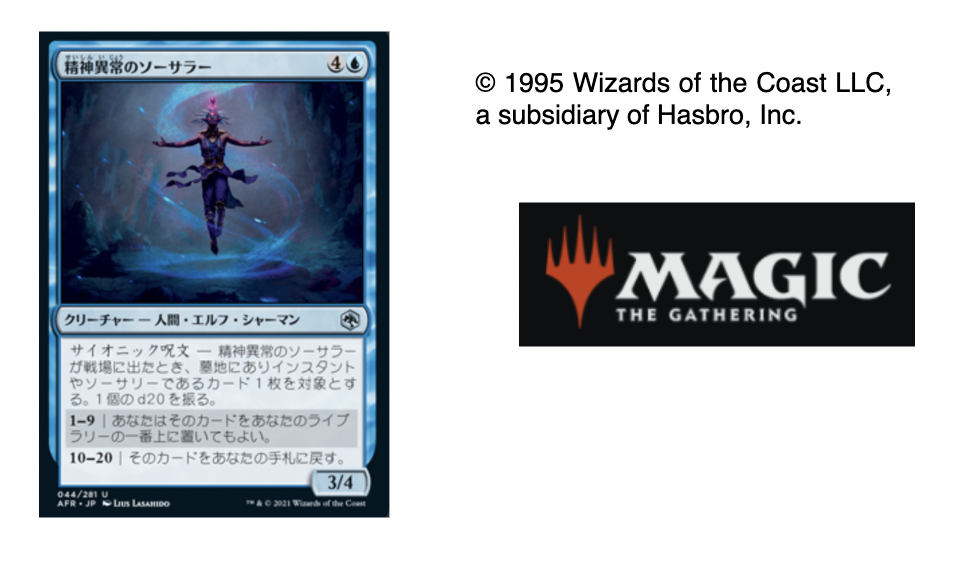

In [3]:
Image("card.png",width = 500)

### 作成するデータセットのイメージ
構築するデータセットの一部を先に示しておきます。
コラムは「カード名」、「タイプ」、「効果テキスト」の３つで各行にそれらに対応するカードのデータがあります。


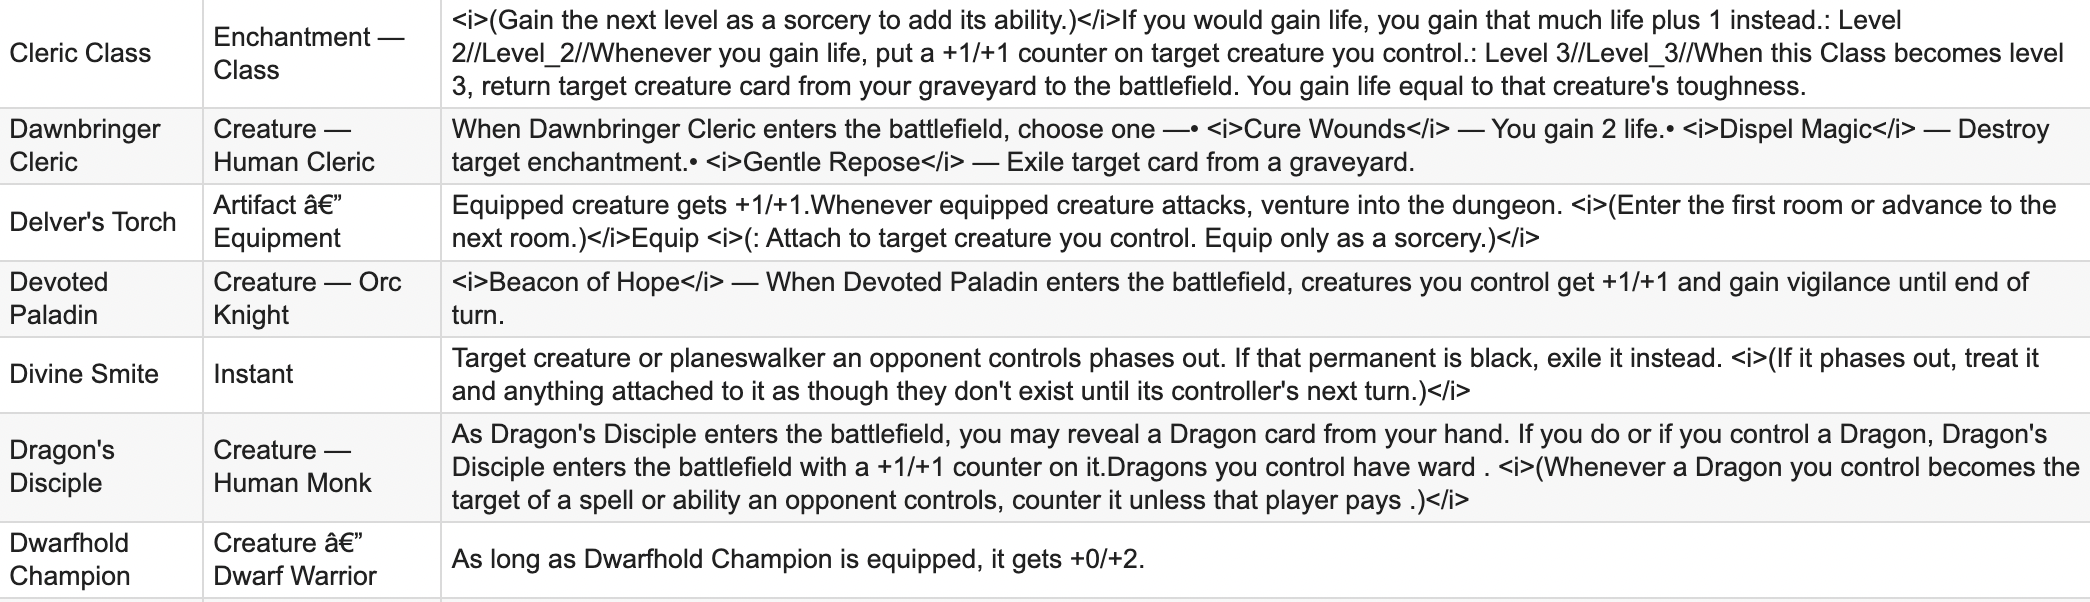

In [13]:
Image("dataset.png",width = 900)

作成手順は
1. 取得元となる Web ページを探す
2. コード作成
です。順に説明していきます。

まず、取得元となる Web ページを探します。今回の例ではカードゲームの公式サイト内にある[データ閲覧ページ](https://gatherer.wizards.com/Pages/Default.aspx)を選びました。
データの表示が規則的で取得しやすく信頼性がある Web ページを選びましょう。

次に、コードの作成です。まずは取得するデータが表示されている Web ページの構成を探ります。GoogleChrome の検証機能がおすすめです。実際にその機能を用いると以下に表示されているような HTML 構成をしていることがわかります。HTML について基礎的な知識があることを前提に説明を進めます。

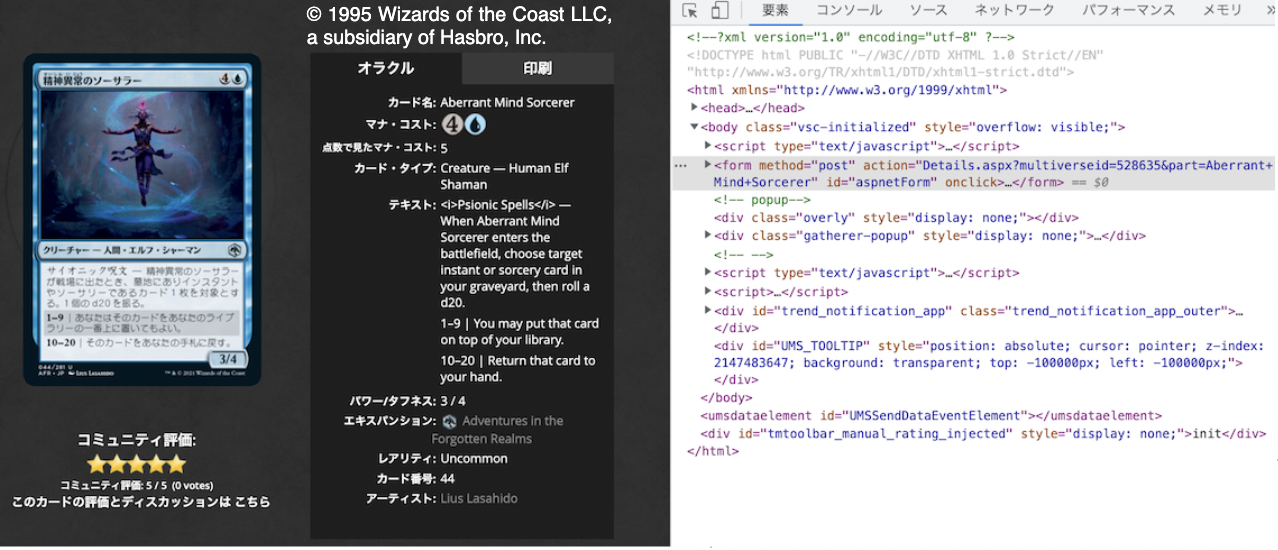

In [7]:
Image("html.png",width = 900)

### コードの説明

まず、ライブラリを Import します。Requests は Web ページ情報取得のため、BeautifulSoup は HTMLテキストから要素を抽出するためのものです。

In [4]:
# import 先頭　２ つは重要な役割
from bs4 import BeautifulSoup
import requests as req

import pandas as pd
import re
from tqdm import tqdm
import traceback
import warnings
warnings.simplefilter("ignore")

# 後ほど説明
from time import sleep

最終的には複数枚のカードデータを取得しますが、まずは例で挙げた 1 枚のカードのデータのみ取得してみます。 Web ページの URL を用いることで HTML テキストを取得します。




In [17]:
# 取得元となる Web ページの URL 
url="https://gatherer.wizards.com/Pages/Card/Details.aspx?multiverseid=528635&part=Aberrant+Mind+Sorcerer"

# この時点では要らないが後で重要になる　[必須]サーバー負荷対策
sleep(1)
# ページ情報の取得
response = req.get(url, verify=False)
response.encoding = response.apparent_encoding
soup = BeautifulSoup(response.text, "html.parser")

print(soup)

<?xml version="1.0" encoding="utf-8" ?>
<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Strict//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-strict.dtd">

<html xmlns="http://www.w3.org/1999/xhtml">
<head><meta content="IE=edge" http-equiv="X-UA-Compatible"/><title>
	精神異常のソーサラー (Adventures in the Forgotten Realms) - Gatherer - Magic: The Gathering
</title><link href="/Images/favicon.ico" rel="shortcut icon"/><meta content="Gatherer is the Magic Card Database. Search for the perfect addition to your deck. Browse through cards from Magic's entire history. See cards from the most recent sets and discover what players just like you are saying about them." name="description"/><meta content="monitor, gatherer, magic cards, magic the gathering, black lotus, magic: the gathering, wizards of the coast, wizards, trading card game, trading cards, collectible card game, tcg, ccg, magic sets, game, multiplayer, hobby" name="keywords"/><meta content="#191919" name="theme-color"/><meta content="#191919" 

sleep(1) は後で複数枚のカードデータを自動取得する際に、サーバーへの過剰な負荷を防ぐために必須であるので、
```
# この時点では要らないが後で重要になる　[必須]サーバー負荷対策
sleep(1)
# ページ情報の取得
response = req.get(url, verify=False)
response.encoding = response.apparent_encoding
soup = BeautifulSoup(response.text, "html.parser")

```
これらは一塊で認識しておきましょう。

続いて、膨大な量のテキストからデータを抽出していきます。

bs4 を用いることで数行で取得したいデータを得ることができます。

In [18]:
datas = soup.find_all("div", class_="row")
for data in datas:
  label = data.find("div", class_="label").get_text().strip()
  value = data.find("div",class_="value").get_text().strip()

  if label == "Card Name:":
    print(f"カード名:      { value }")
    continue
  if label == "Types:":
    print(f"タイプ:      { value }")
    continue
  if label == "Card Text:":
    print(f"効果テキスト:      { value }")
    continue

カード名:      Aberrant Mind Sorcerer
タイプ:      Creature  — Human Elf Shaman
効果テキスト:      <i>Psionic Spells</i> — When Aberrant Mind Sorcerer enters the battlefield, choose target instant or sorcery card in your graveyard, then roll a d20.1–9 | You may put that card on top of your library.10–20 | Return that card to your hand.


### 複数枚のカードデータを自動取得
他のカードデータも取得していきます。

[カード一覧表示ページ](https://gatherer.wizards.com/Pages/Search/Default.aspx?page=0&set=[%22Adventures+in+the+Forgotten+Realms%22])には各カードデータの表示ページ URL が全て載っています。

例 1 ) https://gatherer.wizards.com/Pages/Card/Details.aspx?multiverseid=528635

例 2 ) https://gatherer.wizards.com/Pages/Card/Details.aspx?multiverseid=528678&part=Acererak+the+Archlich

これらを比較すると URL に規則性があることがわかります。



> URL = 共通 + 各カード固有の文字列



この規則性を利用することで自動でデータを取得します。

In [5]:
# カード一覧表示ページの URL
url = "https://gatherer.wizards.com/Pages/Search/Default.aspx?page=0&set=[%22Adventures+in+the+Forgotten+Realms%22]&sort=cn+"

# [必須]サーバー負荷対策
sleep(1)
# ページ情報の取得
response=req.get(url, verify=False)
response.encoding=response.apparent_encoding
soup=BeautifulSoup(response.text, "html.parser")

info=soup.find_all("a")
count3 = 0
# 各カードデータの表示ページの URL に含まれる各カード固有の文字列を格納
uniques = []

# 各カードデータ表示ページの URL の取得
for data in info:
  unique = re.findall(r"multiverseid=\d+", data.get("href"))
  if len(unique) != 0 and count3%3 == 0:
    uniques.append(unique)
  count3 += 1

print(uniques)

[['multiverseid=527293'], ['multiverseid=527296'], ['multiverseid=527297'], ['multiverseid=527298'], ['multiverseid=527299'], ['multiverseid=527300'], ['multiverseid=527301'], ['multiverseid=527303'], ['multiverseid=527306'], ['multiverseid=527308'], ['multiverseid=527309'], ['multiverseid=527311'], ['multiverseid=527312'], ['multiverseid=527313'], ['multiverseid=527316'], ['multiverseid=527317'], ['multiverseid=527318'], ['multiverseid=527319'], ['multiverseid=527320'], ['multiverseid=527321'], ['multiverseid=527322'], ['multiverseid=527323'], ['multiverseid=527324'], ['multiverseid=527325'], ['multiverseid=527327'], ['multiverseid=527329'], ['multiverseid=527330'], ['multiverseid=527331'], ['multiverseid=527332'], ['multiverseid=527333'], ['multiverseid=527334'], ['multiverseid=527337'], ['multiverseid=527338'], ['multiverseid=527339'], ['multiverseid=527344'], ['multiverseid=527345'], ['multiverseid=527346'], ['multiverseid=527348'], ['multiverseid=527352'], ['multiverseid=527354'],

詳細は省きますが各カードデータの表示ページに対応する固有の文字列を取得することができました。

後は for 文を用いて繰り返し処理をします。この際に、Web ページに時間間隔を空けてアクセス (sleep(1)) しないとサーバーに集中的な**アクセス負荷**をかけてしまいます。最低 1 秒は空けるようにしましょう。

進捗や取得終了時間の見込みを知ることができる便利なライブラリに tqdm があります。また、for 文内では try と traceback を用いることで例外への対策をしています。

In [6]:
# 各表示ページのURLの共通部分
s="https://gatherer.wizards.com/Pages/Card/Details.aspx?"

# 各取得データを格納
CardName = []
Type = []
Text =[]

for unique in tqdm(uniques):
  try :
    # 取得元となる Web ページの URL 
    url = s + unique[0]

    # 　[必須]サーバー負荷対策
    sleep(1)
    # ページ情報の取得
    response = req.get(url, verify=False)
    response.encoding = response.apparent_encoding
    soup = BeautifulSoup(response.text, "html.parser")

    datas = soup.find_all("div", class_="row")

    for data in datas:
      label = data.find("div", class_="label").get_text().strip()
      value = data.find("div",class_="value").get_text().strip()

      if label == "Card Name:":
        CardName.append(value)
        continue
      if label == "Types:":
        Type.append(value)
        continue
      if label == "Card Text:":
        Text.append(value)
        continue

  except :
    print(url)
    print(traceback.format_exc())

100%|██████████| 100/100 [03:22<00:00,  2.03s/it]


データを取得することができました。最後に取得したデータをデータフレーム化することでデータセットの構築を完了とします。

In [8]:
df = pd.DataFrame()
df["CardName"] = CardName
df["Type"] = Type
df["Text"] = Text

print(df.head())

             CardName                      Type  \
0        Cleric Class      Enchantment  — Class   
1  Dawnbringer Cleric  Creature  — Human Cleric   
2      Delver's Torch   Artifact  â€” Equipment   
3     Devoted Paladin    Creature  — Orc Knight   
4        Divine Smite                   Instant   

                                                Text  
0  <i>(Gain the next level as a sorcery to add it...  
1  When Dawnbringer Cleric enters the battlefield...  
2  Equipped creature gets +1/+1.Whenever equipped...  
3  <i>Beacon of Hope</i> — When Devoted Paladin e...  
4  Target creature or planeswalker an opponent co...  


今回は簡易のため取得要素を少なくし、例外がある際の対策は省略しました。その他気をつけることもあるので Web 上の記事なども参考にしてください。